In [189]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras import Model, Input
from keras.preprocessing import image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import glob
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

### load images

In [43]:
filenames = glob.glob("dataset/*/*.jpg")
print(len(filenames))

# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
all_images = []
labels = []

for idx, img_path in enumerate(filenames):
    label = img_path.split(os.path.sep)[-2]

    img = image.load_img(img_path, target_size=(224, 224), interpolation="nearest")
    img = image.img_to_array(img)
    img = preprocess_input(img) ## using mobilenet_v2

    # update the data and labels lists, respectively
    labels.append(label)
    all_images.append(img)

# convert the data and labels to NumPy arrays
all_images = np.array(all_images, dtype="float32")
labels = np.array(labels)

3762


In [44]:
# perform one-hot encoding on the labels
print(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)
labels = to_categorical(labels)
print(labels)

['with_mask' 'with_mask' 'with_mask' ... 'without_mask' 'without_mask'
 'without_mask']
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


3762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train: 2633 2633
Test: 564 564
Validate: 565 565


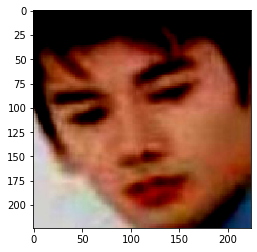

In [135]:
# train    70%
# test     15%
# validate 15%

print(len(all_images))
(trainX, testX, trainY, testY) = train_test_split(all_images, labels, test_size=0.30, stratify=labels, random_state=42)
(testX, valX, testY, valY) = train_test_split(testX, testY, test_size=0.50, stratify=testY, random_state=42)

print('Train:', len(trainX), len(trainY))
print('Test:', len(testX), len(testY))
print('Validate:', len(valX), len(valY))
plt.imshow(trainX[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


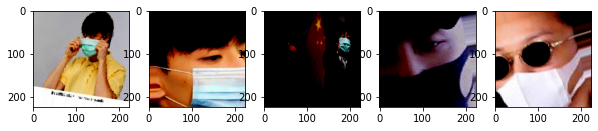

In [184]:
# construct the training image generator for data augmentation
datagen = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range=20,
                        zoom_range=0.15,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.15,
                        horizontal_flip=True,
                        fill_mode="nearest")

plt.figure(figsize=(10,10))

for idx in range(5):
  plt.subplot(1, 5, idx+1)
  pic = datagen.flow(trainX, trainY, batch_size = 32)
  batch = pic.next()
  im_result = (batch[0]*255.0)
  plt.imshow(im_result[0])

In [199]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_squared_error'])

In [212]:
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
batch_size = [8, 16, 32]
epochs = [2,4,6]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)

grid = GridSearchCV( estimator=model,
                      verbose= 0,
                      cv=2,
                      n_jobs=1,
                      param_grid = param_grid)

grid_result = grid.fit(trainX, trainY)
print('Best params: ', grid_result.best_params_)
print('Best score: ', grid_result.best_score_) 
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.functional.Functional object at 0x2baa5edc0> does not.